In [164]:
# standard libs
import os
import sys
import logging
import json

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
from prediction_age import AgePredictor, AgePredictorComparison
from preprocessing import *
from fragmented_cities import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import shap
from functools import partial

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

In [3]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
%load_ext autoreload
%autoreload 2

## Data

In [78]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)

In [ ]:
data_geom = pd.read_csv(os.path.join('..', 'data', 'france-gov_geom.csv'))

In [42]:
data_boundaries_fra = gpd.read_file(os.path.join('..', 'data', 'gadm', 'gadm36_FRA_4.shp'))

In [36]:
data_boundaries = gpd.read_file(os.path.join('..', 'data', 'gadm', 'gadm404.gpkg'))

In [39]:
european_countries = [
'Albania',
'Austria',
'Belgium',
'Bulgaria',
'Croatia',
'Cyprus',
'Czechia',
'Denmark',
'Estonia',
'Finland',
'France',
'Germany',
'Greece',
'Greenland',
'Hungary',
'Iceland',
'Ireland',
'Italy',
'Kosovo',
'Liechtenstein',
'Lithuania',
'Luxembourg',
'Monaco',
'Montenegro',
'Netherlands',
'North Macedonia',
'Northern Cyprus',
'Norway',
'Poland',
'Portugal',
'Romania',
'San Marino',
'Serbia',
'Slovakia',
'Slovenia',
'Spain',
'Sweden',
'Switzerland',
'Ukraine',
# 'United Kingdom'
]
data_boundaries_europe = data_boundaries[data_boundaries['NAME_0'].isin(european_countries)]

## Determining fragmented cities semi-automatically

### STEP 0: Preprocessing

In [170]:
df = data_boundaries_europe.copy()
df = df.drop_duplicates(subset=['NAME_0', 'NAME_1', 'NAME_2', 'NAME_3', 'NAME_4'])

### STEP 1: Europe-wide city clustering based on similar names to get an intuition of possibly fragmented regions (GADM level 4)

In [166]:
for level in [3, 4]:

    candidates = {}
    for country in european_countries:
        data_boundaries_country = df[df['NAME_0'] == country]
        candidates[country] = get_fragmented_cities_clustering(data_boundaries_country, level=level)

    with open(os.path.join('..', 'data', f'fragmented-cities-candidates-clustering-level-{level}.json'), 'w', encoding='utf8') as f:
        json.dump(candidates, f, sort_keys=True, indent=4, ensure_ascii=False)


### STEP 2: Analysis of potential fragmented regions

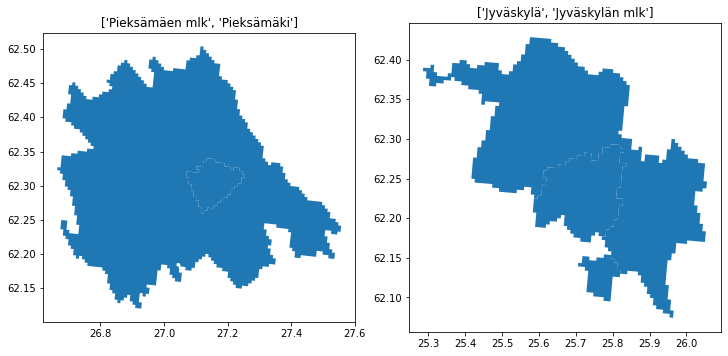

In [181]:
# Finland (level 4)
df_fn = data_boundaries[data_boundaries['NAME_0'] == 'Finland'].copy()
frag_cities_fn = get_fragmented_cities_clustering(df_fn, level=4)

# mlk (Finnish): Abbreviation of maalaiskunta ("rural municipality")
mlk_frag_cities_fn = [frags for frags in frag_cities_fn if any('mlk' in frag for frag in frags)]
visual_validation(mlk_frag_cities_fn, df_fn, level=4)
# --> tbd if considered as fragmented city / region!

<AxesSubplot:>

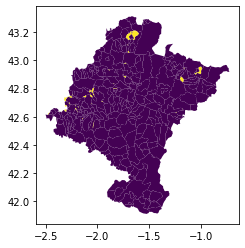

In [179]:
# Facería XX regions in Spain (level 4)
df = data_boundaries[(data_boundaries['NAME_0'] == 'Spain')].copy()
df['Facería_region'] = df['NAME_4'].str.contains('Facería')
df[df['NAME_2'] == 'Navarra'].plot(column='Facería_region')
# --> not a fragmented city / region!

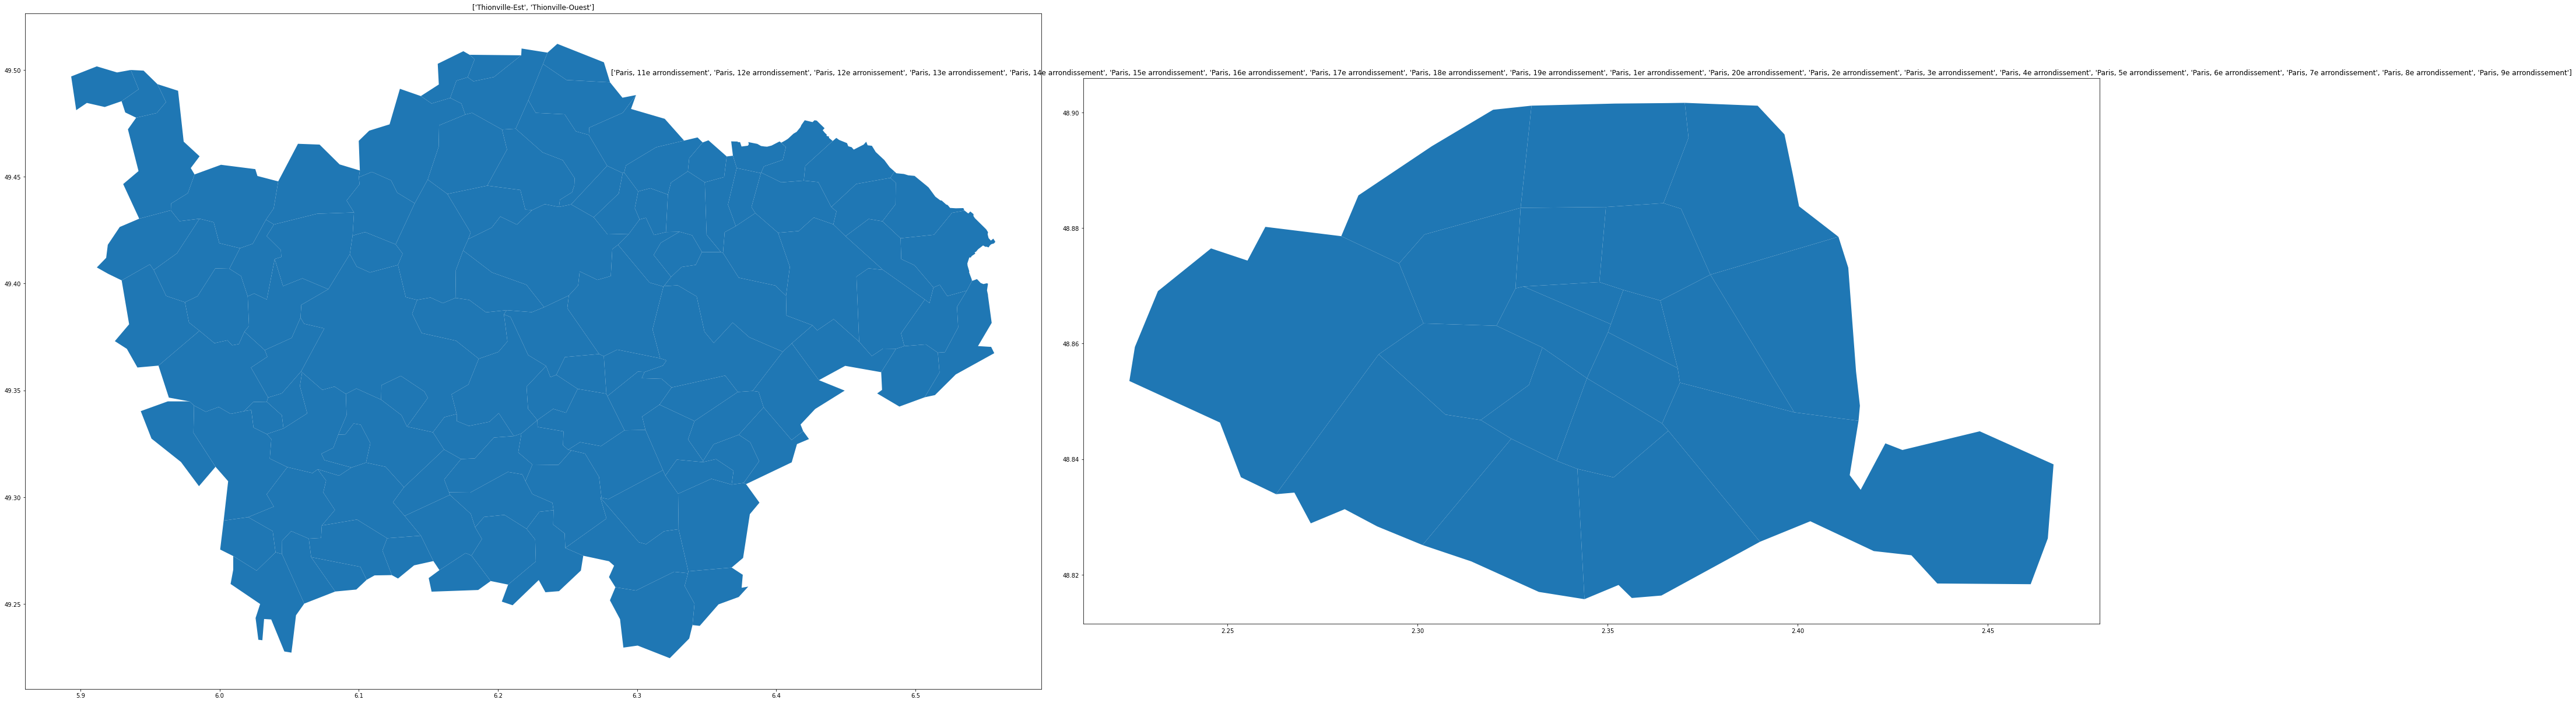

In [194]:
# France (level 3)
df_fr = data_boundaries[data_boundaries['NAME_0'] == 'France'].copy()
frag_cities_fr = get_fragmented_cities_clustering(df_fr, level=3)
visual_validation(frag_cities_fr, df_fr, level=3)

visualizations.plot_attribute_on_map(data_france_region, data_geo_region, 'street_closeness_global_closest_street', boundaries_df=data_boundaries_region) #, vmin=0.001, vmax=0.00001)

# --> Paris: fragmented city / to be merged! Thionville tbd!


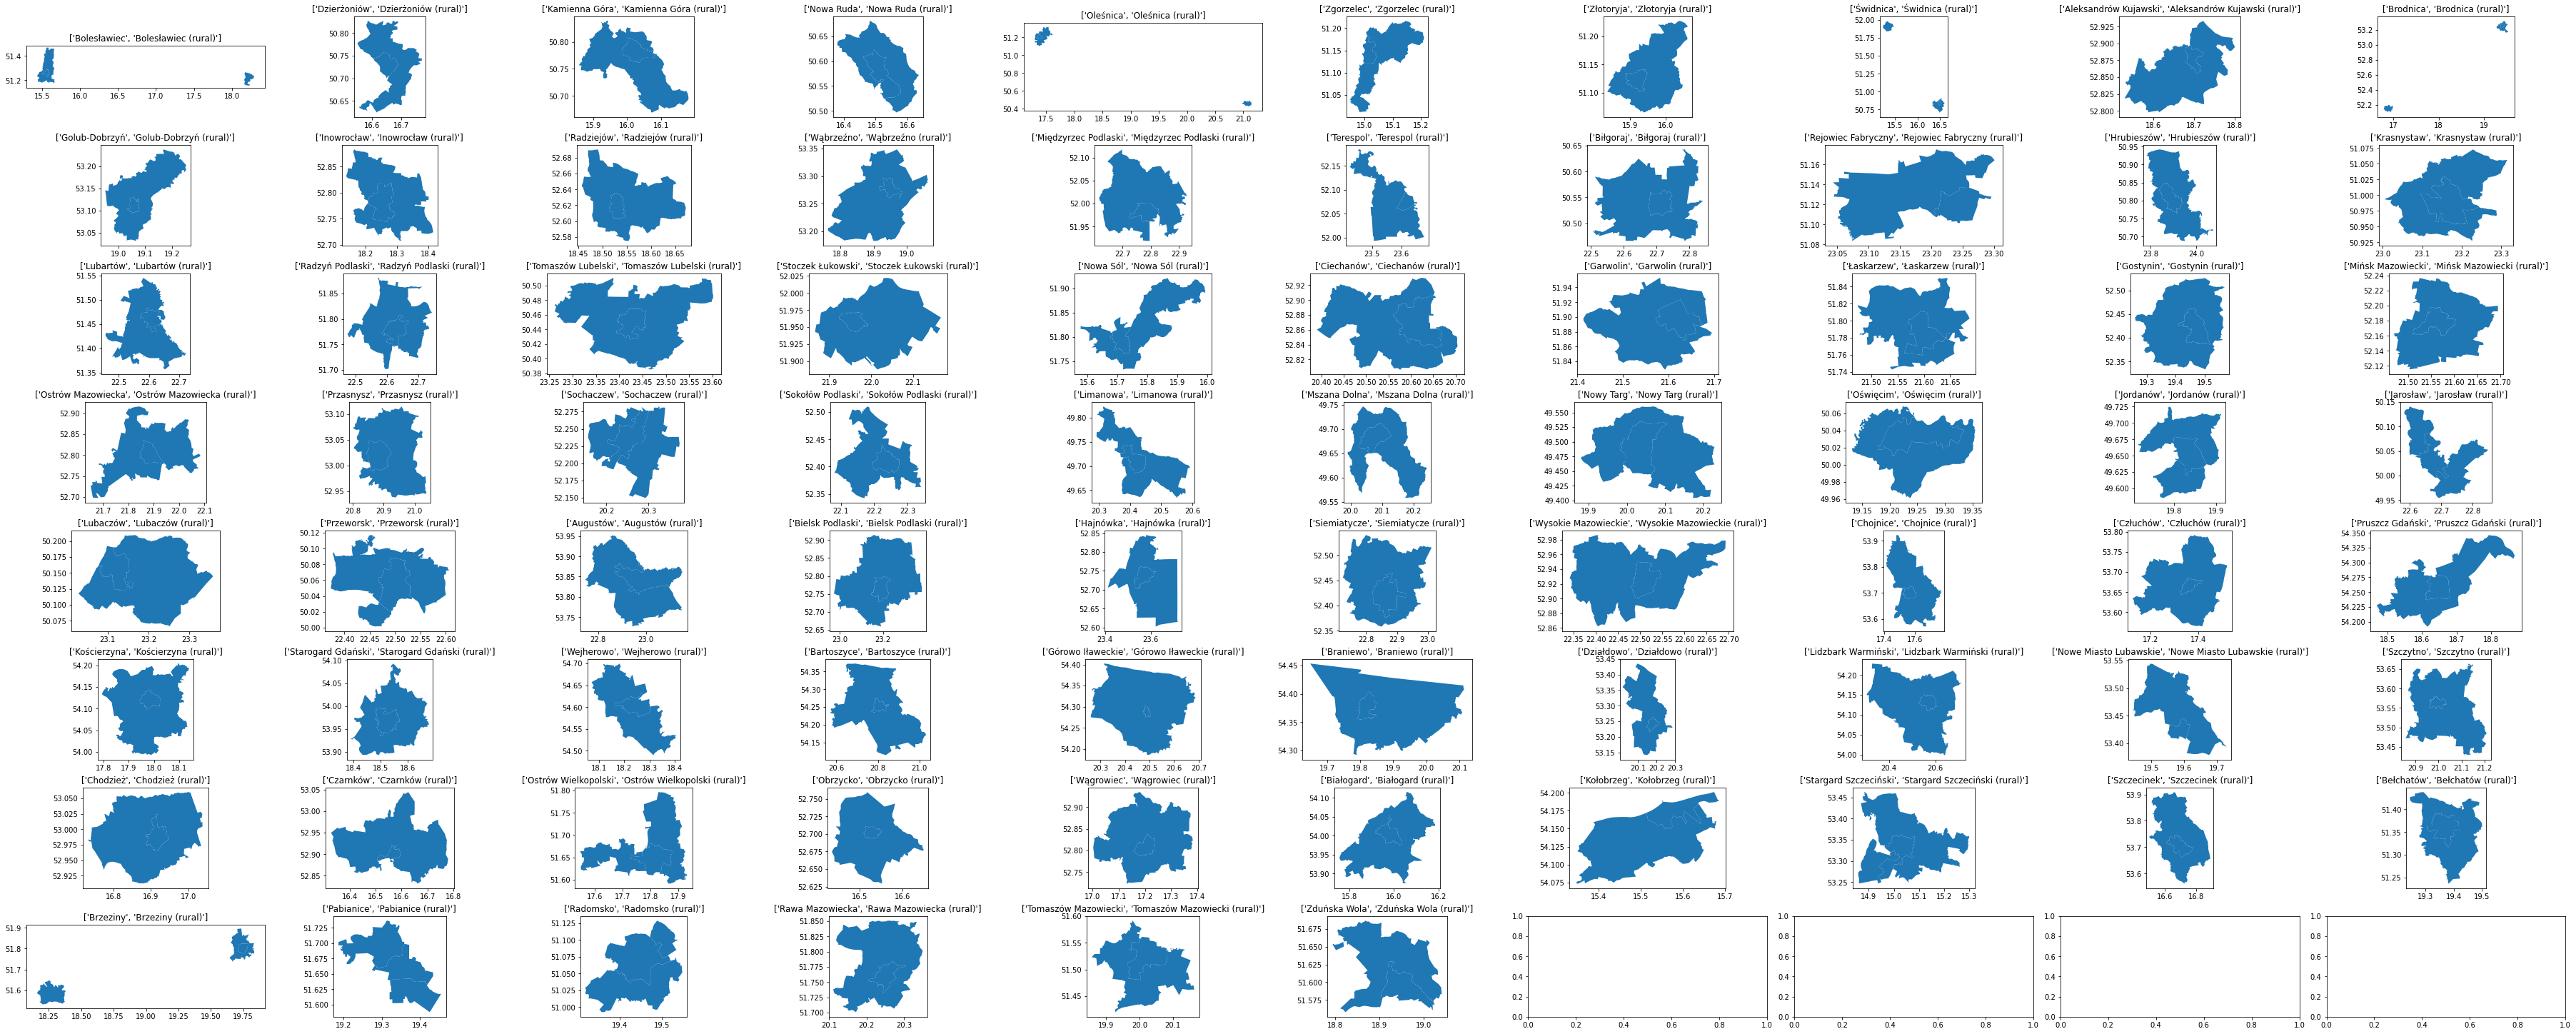

In [191]:
# Poland (level 3)
df_pl = data_boundaries[data_boundaries['NAME_0'] == 'Poland'].copy()
frag_cities_pl = get_fragmented_cities_clustering(df_pl, level=3)

# mlk (Finnish): Abbreviation of maalaiskunta ("rural municipality")
mlk_frag_cities_pl = [frags for frags in frag_cities_pl if any('(rural)' in frag for frag in frags)]
visual_validation(mlk_frag_cities_pl, df_pl, level=3)
# --> tbd if 'rural' considered as fragmented city / region!

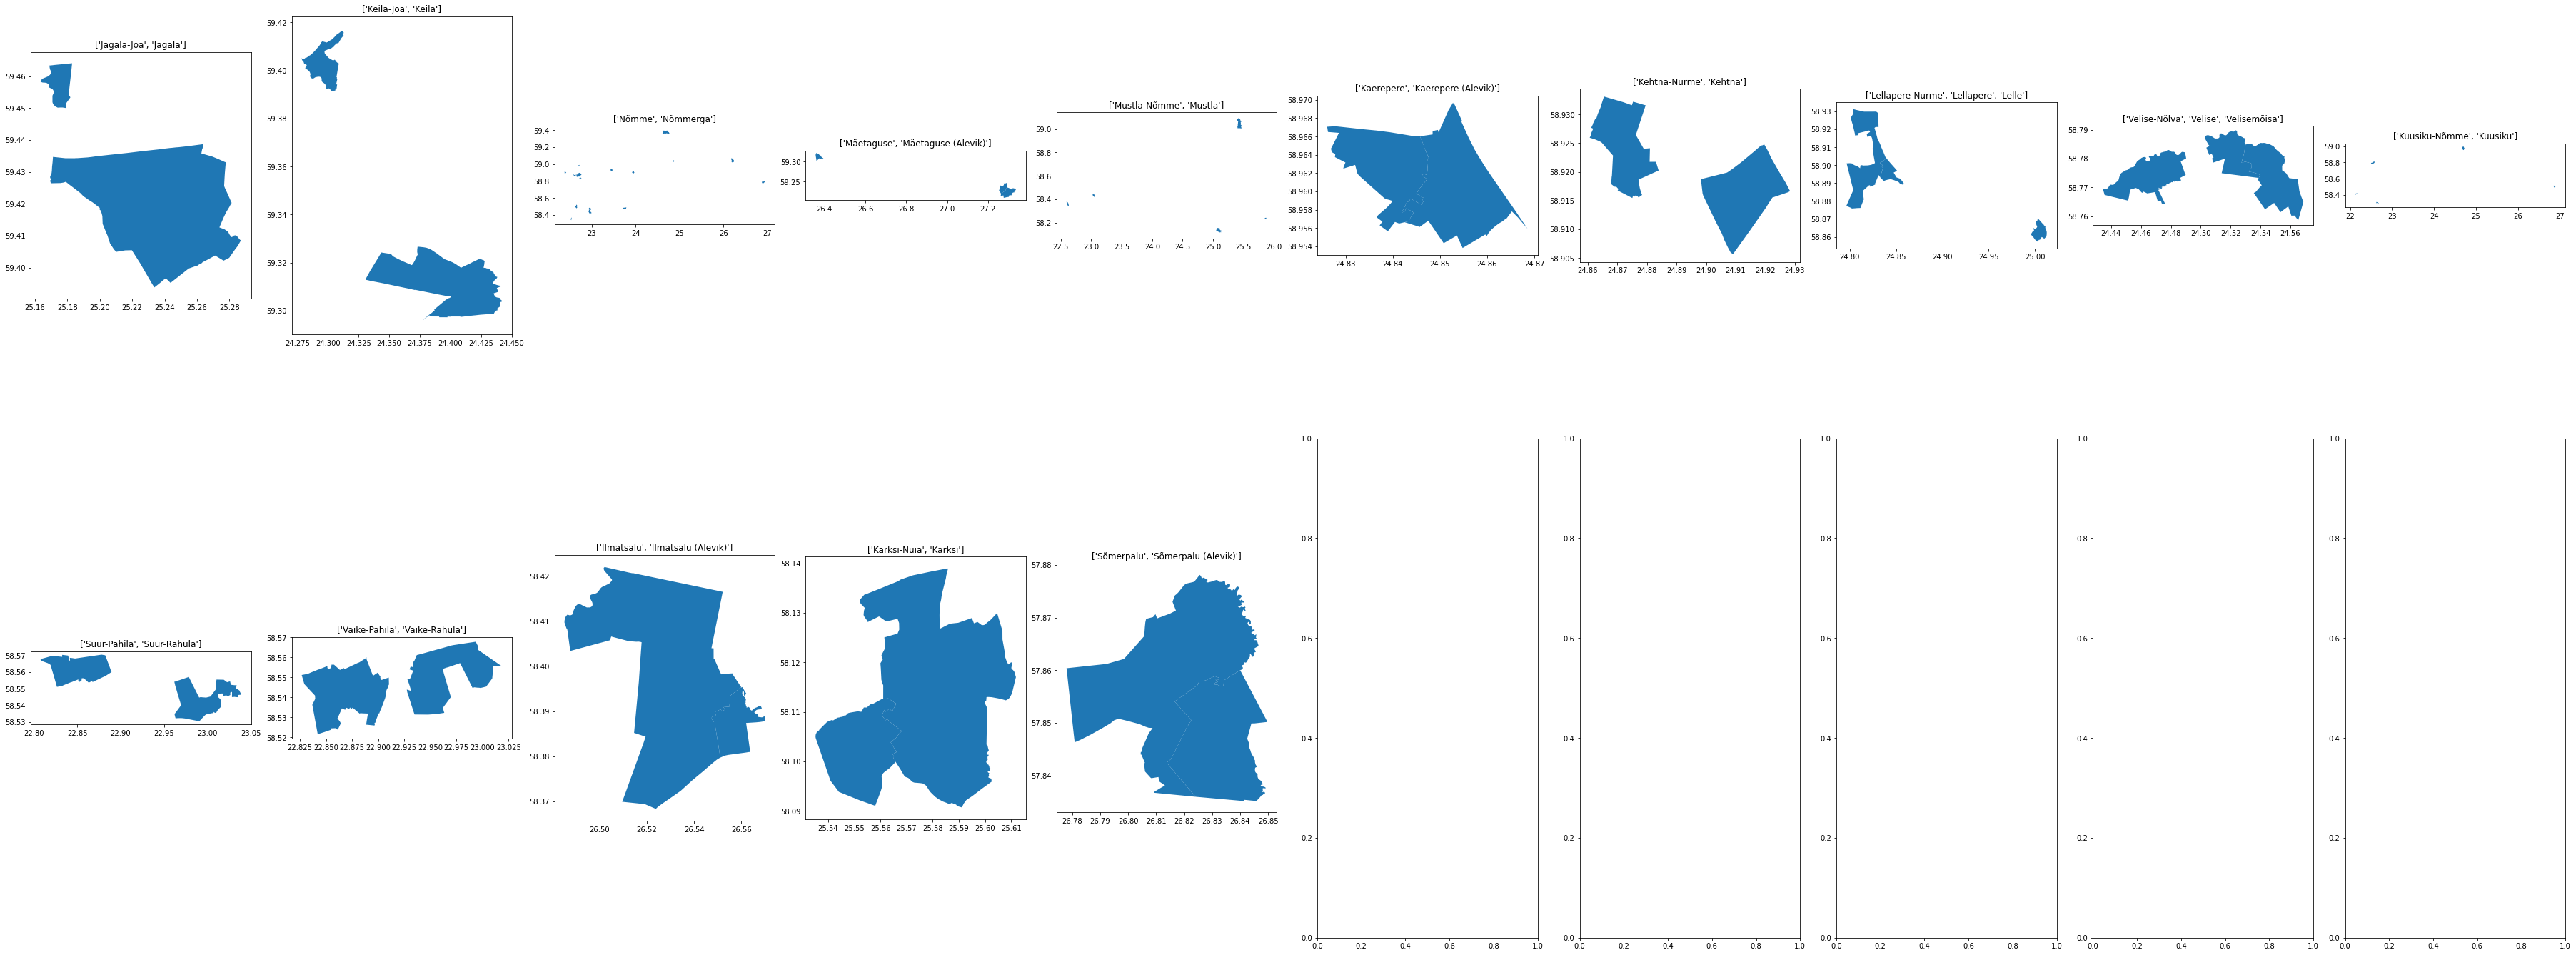

In [184]:
# Estonia (level 3)
potential_substrings = ['Joa', 'Alevik', 'Pahila', 'Rahula', 'Nõmme', 'Nurme'] # used at least twice
potential_substrings_2 = ['Nõlva', 'Nuia'] # used just once

df_es = data_boundaries[data_boundaries['NAME_0'] == 'Estonia'].copy()
frag_cities_es = get_fragmented_cities_clustering(df_es, level=3)
mlk_frag_cities_es = [frags for frags in frag_cities_es if any(s in frag for frag in frags for s in potential_substrings + potential_substrings_2)]
visual_validation(mlk_frag_cities_es, df_es, level=3)

# --> tbd if 'Alevik' (eng.: village) is considered as fragmented city / region; all others are not!

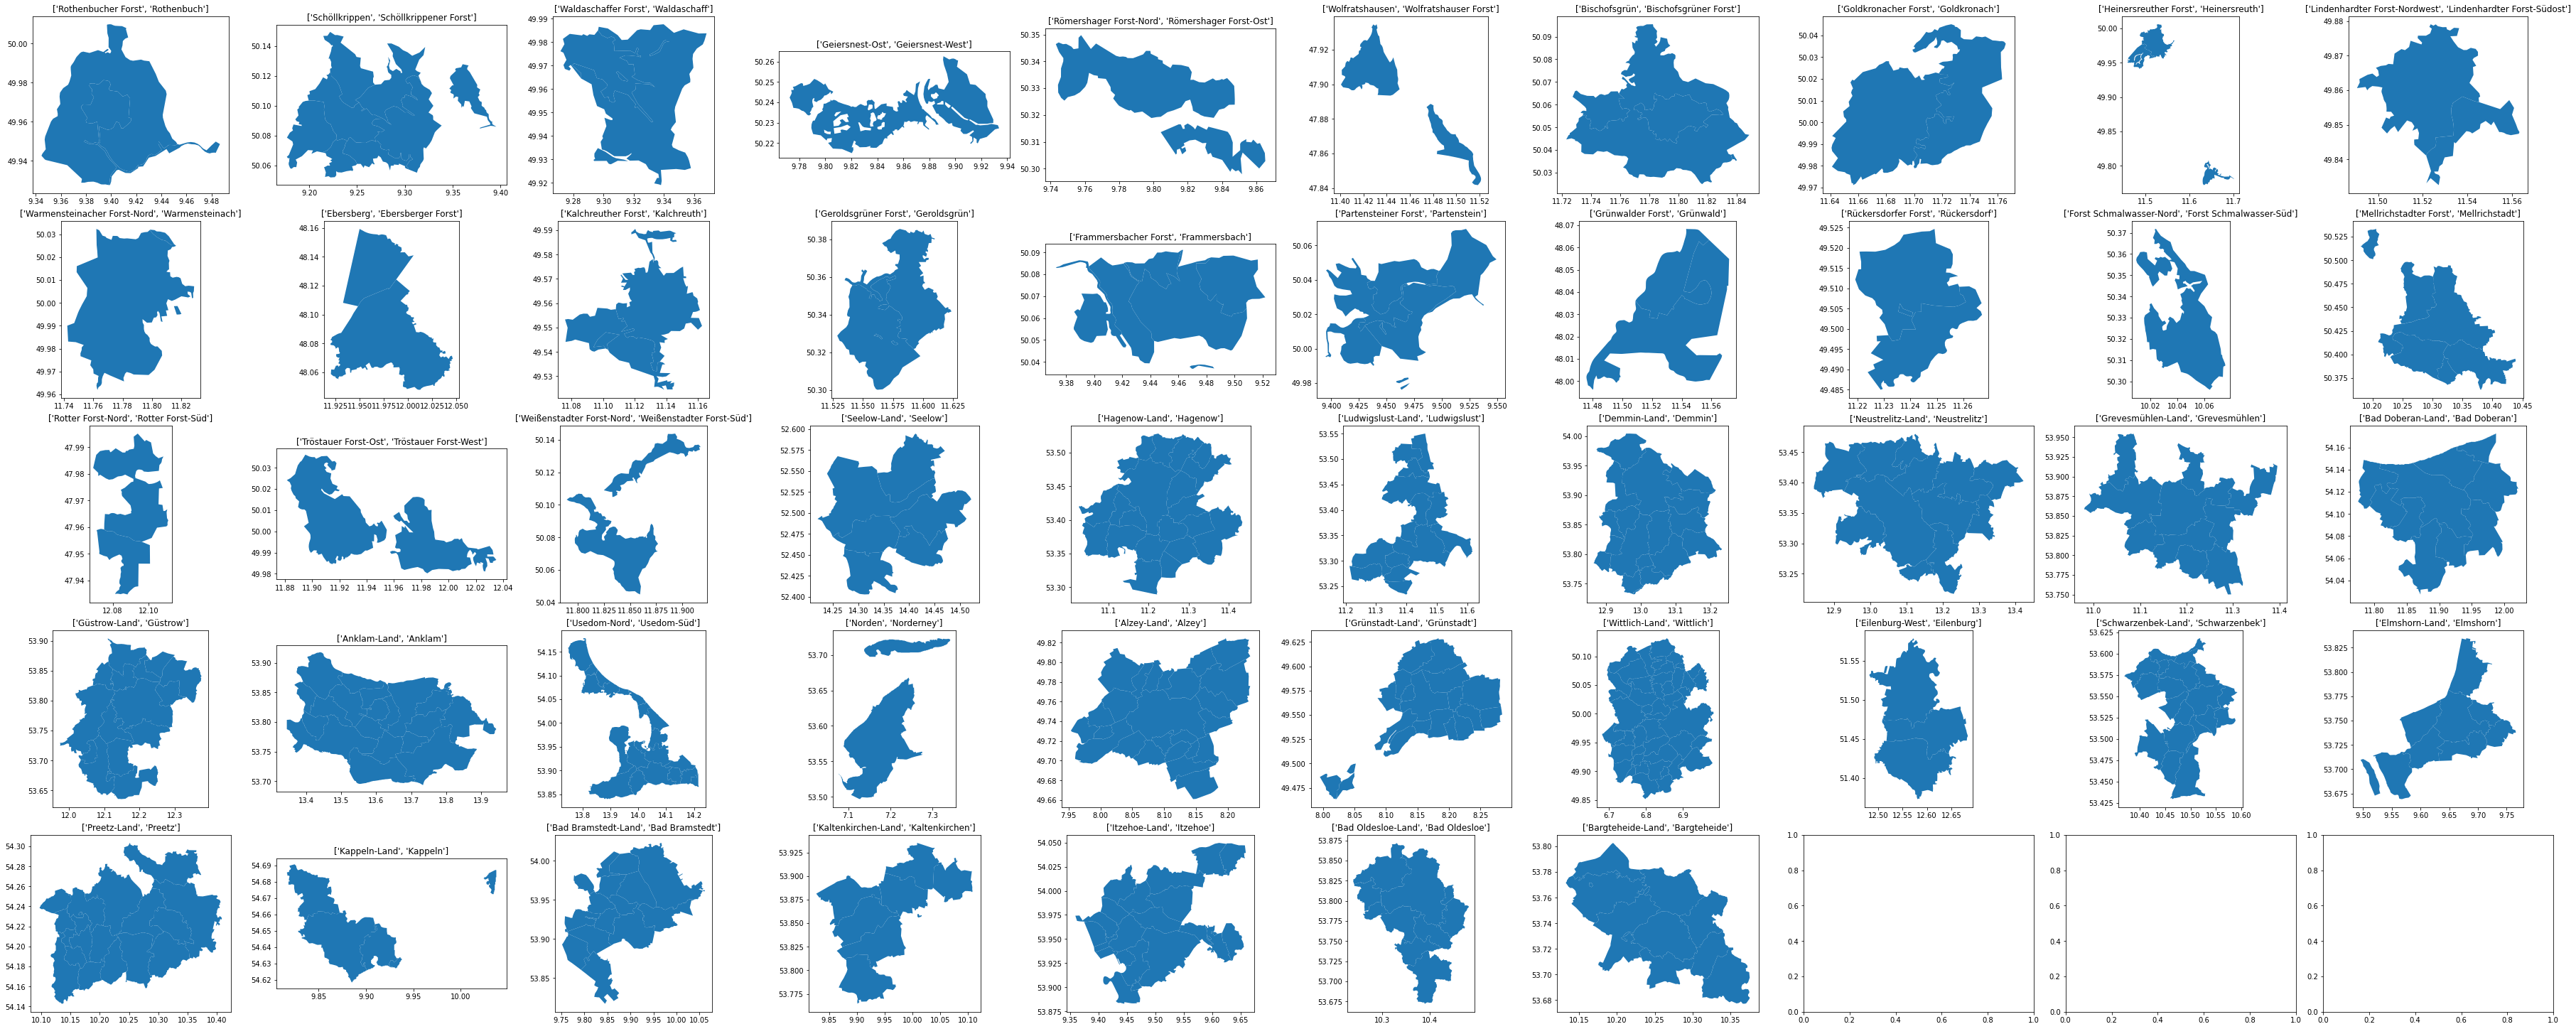

In [193]:
# Germany (level 3)
potential_substrings = ['-Land', 'Nord', 'Süd', 'West', 'Ost', 'Forst'] # used at least twice

df_ger = data_boundaries[data_boundaries['NAME_0'] == 'Germany'].copy()
frag_cities_es = get_fragmented_cities_clustering(df_ger, level=3)
mlk_frag_cities_es = [frags for frags in frag_cities_es if any(s in frag for frag in frags for s in potential_substrings)]
visual_validation(mlk_frag_cities_es, df_ger, level=3)

# --> ?

In [196]:
# Italy (level 3)

# --> ?

#### TBD

In [192]:
# Should rural areas and rural municipalities be joined? Probably not. Then ignore 'Alevik', 'mlk' and 'rural' substrings

### STEP 3a: Determining substrings which hint fragmented cities

### STEP 3b: Determining special cases of fragmented cities which have to be hard-coded

### STEP 4: Determining fragmented city based on regex parsing for substrings

In [ ]:
for country in european_countries:
    data_boundaries_country = df[df['NAME_0'] == country]
    print(country)
    print(get_fragmented_level_4_cities_regex(data_boundaries_country))


## Validation

### Validation: difference between clustering and regex approach

In [200]:
df = data_boundaries[data_boundaries['NAME_0'] == 'France'].copy()

fragmented_cities_regex = set(flatten(get_fragmented_level_4_cities_regex(df)))
fragmented_cities_clustering = set(flatten(get_fragmented_cities_clustering(df, level=4)))

print(sorted(fragmented_cities_regex - fragmented_cities_clustering))
print(sorted(fragmented_cities_clustering - fragmented_cities_regex))

# -> regex finds all relevant cities from clustering approach (for France)

['Agen', 'Agen-Ouest', 'Ajaccio', 'Ajaccio 7e Canton', 'Alençon', 'Alès', 'Alès-Ouest', 'Amiens', 'Annecy', 'Annecy-Nord-Ouest', 'Auch', 'Auch-Sud-Est-Seissan', 'Auch-Sud-Ouest', 'Aurillac', 'Bailleul', 'Bailleul-Nord-Est', 'Bailleul-Sud-Ouest', 'Bastia', 'Bastia 6e (Canton Furiani-Montésoro)', 'Beauvais', 'Bergerac', 'Bergerac 2e Canton', 'Blois', 'Béziers', 'Caen', 'Calais-Nord-Ouest', 'Cholet', 'Dax', 'Dax-Nord', 'Dax-Sud', 'Dijon', 'Dole', 'Dole-Nord-Est', 'Dole-Sud-Ouest', 'Laon-Nord', 'Le Havre', 'Le Havre 6e Canton', 'Le Mans', 'Lisieux', 'Lure-Nord', 'Mandelieu-Cannes-Ouest', 'Mazamet', 'Mazamet-Nord-Est', 'Mazamet-Sud-Ouest', 'Moissac', 'Montauban', 'Montluçon', 'Montluçon-Nord-Est (1er Canton)', 'Mérignac', 'Mérignac 2e Canton', 'Mézières-Centre-Ouest', 'Nantes', 'Nantes 10e Canton', 'Nay', 'Nice', 'Nice 13e Canton', 'Niort-Ouest', 'Pau', 'Pau-Sud', 'Perpignan', 'Poitiers', 'Reims', 'Rennes', 'Sens', 'Sens-Ouest', 'Thouars', 'Toul-Nord', 'Toulouse', 'Troyes', 'Vendôme', 'Vier

### Regex Validation

In [ ]:
regex_to_be_tested = fragmented_cities.FRAGMENTED_CITY_REGEX
test_non_matching = [
    'Aix-les-Bains', # straight-forward
    'Aix-les-Bains-Grésy', # straight-forward
    'Saint-Trivier-de-Courtes', # straight-forward
    'Saint-Estève', # cardinal direction included in city name, i.e. ESTève
]
test_machting = [
    'Ajaccio  7e Canton', # canton & double whitespace
    'Aix-en-Provence-Sud', # dash
    'Saint-Étienne-Nord-Ouest-1', # dash with multiple cardinal directions
    'Amiens 3e (Nord-Est)', # paranthesis
    'Amiens 1er (Ouest)', # 1er
    'Montluçon-Sud (3e Canton)', # cardinal directions & canton
    'Aix-les-Bains-Nord-Grésy',
]

assert all(re.match(regex_to_be_tested, city) for city in test_machting)
assert not any(re.match(regex_to_be_tested, city) for city in test_non_matching)

#### Known issues and accepted errors

In [97]:
# Fragmented level 3 regions (i.e. Paris & Thionville)
matches = [re.match(FRAGMENTED_CITY_REGEX, city) for city in data_boundaries['NAME_3'].unique()]
print('\nThionville level 3 regions :')
print({m.string for m in matches if m is not None})

print('\nThionville level 4 regions :')
print(sorted(list(data_boundaries[data_boundaries['NAME_3'].str.contains('Thionville')]['NAME_4'].unique())))
print('\nParis level 3 regions :')
print(sorted(list(data_boundaries[data_boundaries['NAME_3'].str.contains('Paris')]['NAME_3'].unique())))

# using .str.contains misses cities with 'basename' and doesn't validate if cities are the same level 3 region
fragmented_cities = flatten(get_fragmented_level_4_cities_regex(data_boundaries))
print('\nCities missed:')
print(set(data_france[data_france['city'].isin(fragmented_cities)]['city'].unique()) - set(data_france[data_france['city'].str.contains('-Nord|-Sud|-Est|-Ouest|Canton')]['city'].unique()))

# Accepted errors:
# * Matching only cities if base name (after cutting Nord, eat, canton etc.) is the same (e.g. Domérat-Montluçon-Nord-Ouest will not be merged with Montluçon, Montluçon-Est (4e Canton), …; otherwise it would be impossible to differentiate which ‘Saint’ cities belong together and which do not)
# * Does not match cities if cardinal directions are in the middle of the city name, e.g. Aix-les-Bains-Grésy is not matched with Aix-les-Bains-Nord-Grésy


Thionville level 3 regions :
{'Paris, 4e arrondissement', 'Paris, 19e arrondissement', 'Paris, 3e arrondissement', 'Paris, 14e arrondissement', 'Paris, 15e arrondissement', 'Paris, 9e arrondissement', 'Paris, 6e arrondissement', 'Paris, 11e arrondissement', 'Thionville-Ouest', 'Thionville-Est', 'Paris, 17e arrondissement', 'Paris, 18e arrondissement', 'Paris, 13e arrondissement', 'Paris, 12e arrondissement', 'Paris, 8e arrondissement', 'Paris, 1er arrondissement', 'Paris, 2e arrondissement', 'Paris, 20e arrondissement', 'Paris, 16e arrondissement', 'Paris, 7e arrondissement', 'Paris, 5e arrondissement'}

Thionville level 4 regions :
['Algrange', 'Cattenom', 'Fameck', 'Florange', 'Fontoy', 'Hayange', 'Metzervisse', 'Moyeuvre-Grande', 'Sierck-les-Bains', 'Thionville', 'Yutz']

Paris level 3 regions :
['Paris, 11e arrondissement', 'Paris, 12e arrondissement', 'Paris, 12e arronissement', 'Paris, 13e arrondissement', 'Paris, 14e arrondissement', 'Paris, 15e arrondissement', 'Paris, 16e arr

#### Experiments

In [65]:
df = data_boundaries[data_boundaries['NAME_4'] == 'Thuir']
df.groupby(['NAME_1', 'NAME_2', 'NAME_3'])['NAME_4'].apply(list).values
# data_boundaries[data_boundaries['NAME_4'].str.contains('Fürth')]


array([list(['Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir', 'Thuir'])],
      dtype=object)

In [70]:
df = data_boundaries[data_boundaries['NAME_0'] == 'France']

get_fragmented_level_3_cities_clustering(data_boundaries_fra)

[['Thionville-Est', 'Thionville-Ouest'],
 ['Paris, 11e arrondissement',
  'Paris, 12e arrondissement',
  'Paris, 12e arronissement',
  'Paris, 13e arrondissement',
  'Paris, 14e arrondissement',
  'Paris, 15e arrondissement',
  'Paris, 16e arrondissement',
  'Paris, 17e arrondissement',
  'Paris, 18e arrondissement',
  'Paris, 19e arrondissement',
  'Paris, 1er arrondissement',
  'Paris, 20e arrondissement',
  'Paris, 2e arrondissement',
  'Paris, 3e arrondissement',
  'Paris, 4e arrondissement',
  'Paris, 5e arrondissement',
  'Paris, 6e arrondissement',
  'Paris, 7e arrondissement',
  'Paris, 8e arrondissement',
  'Paris, 9e arrondissement']]

<AxesSubplot:>

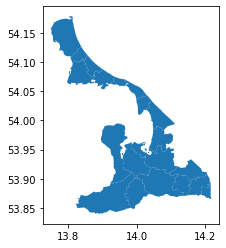

In [75]:
data_boundaries[data_boundaries['NAME_3'].isin(['Usedom-Nord', 'Usedom-Süd'])].plot()


<AxesSubplot:>

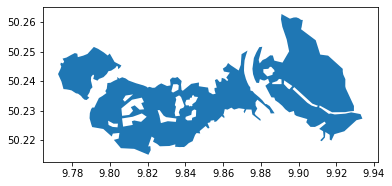

In [76]:
data_boundaries[data_boundaries['NAME_3'].isin(['Geiersnest-Ost', 'Geiersnest-West'])].plot()


<AxesSubplot:>

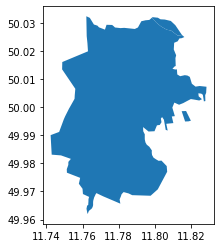

In [79]:
data_boundaries[data_boundaries['NAME_3'].isin(['Warmensteinacher Forst-Nord', 'Warmensteinach'])].plot()


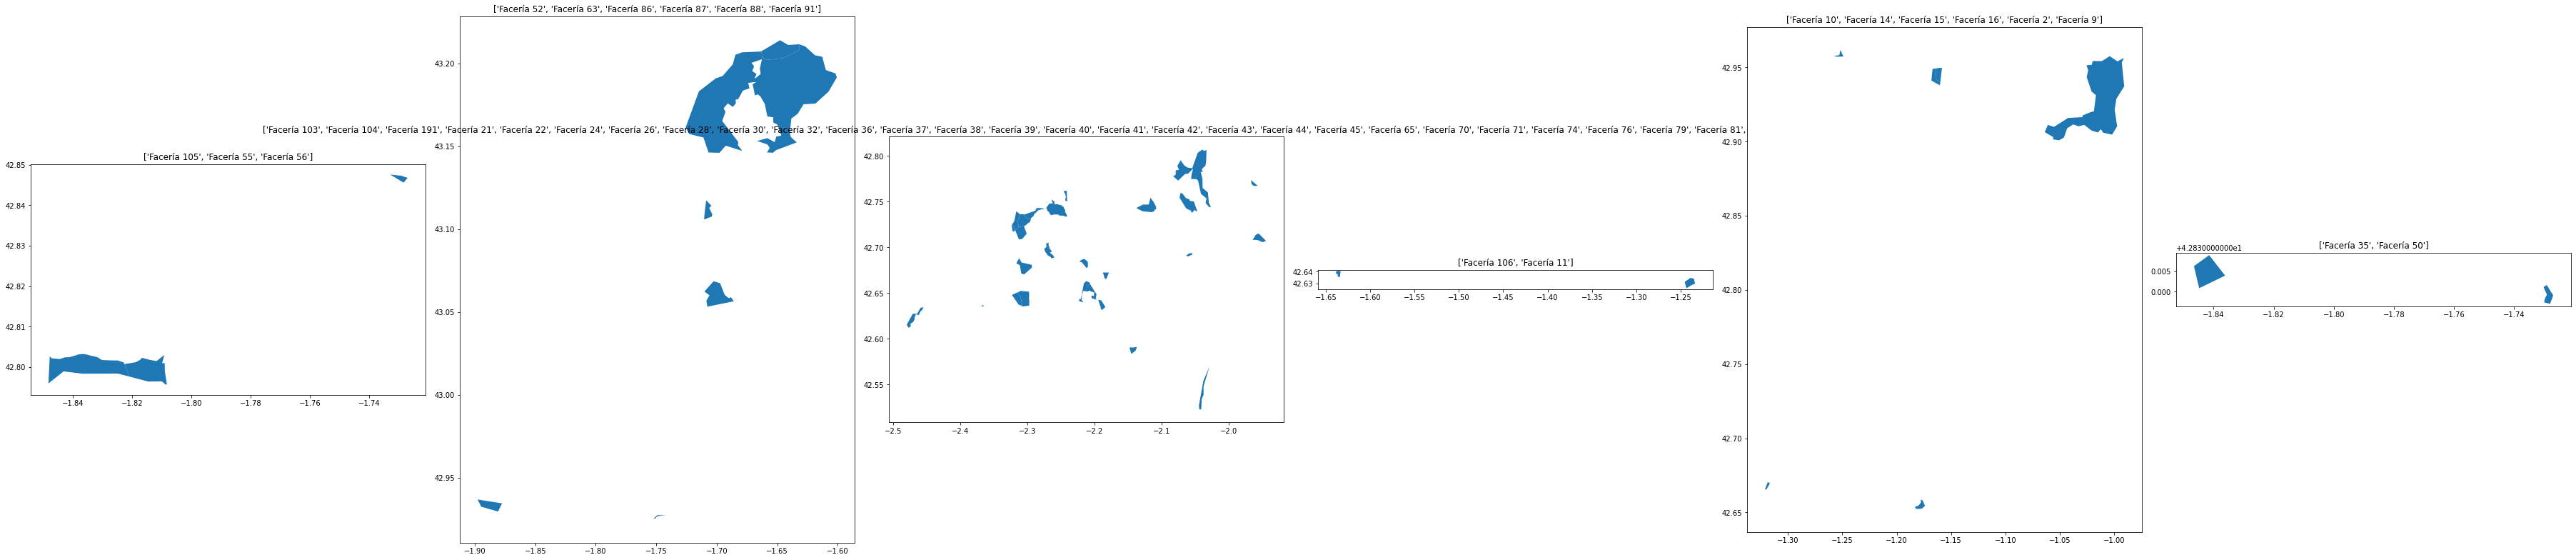

In [197]:
df = data_boundaries[(data_boundaries['NAME_0'] == 'Spain') & (data_boundaries['NAME_4'].str.contains('Facería'))]
frag_cities = get_fragmented_cities_clustering(df, level=4)[:11]
visual_validation(frag_cities, df, level=4)




#### Analysis Facería XX regions in Spain

<AxesSubplot:>

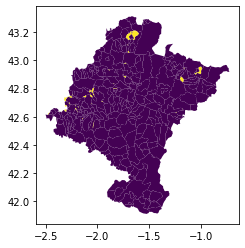

In [151]:
# %matplotlib qt
df = data_boundaries[(data_boundaries['NAME_0'] == 'Spain')].copy()
df['Facería_region'] = df['NAME_4'].str.contains('Facería')
df[df['NAME_2'] == 'Navarra'].plot(column='Facería_region')
# --> not a fragmented city / region!

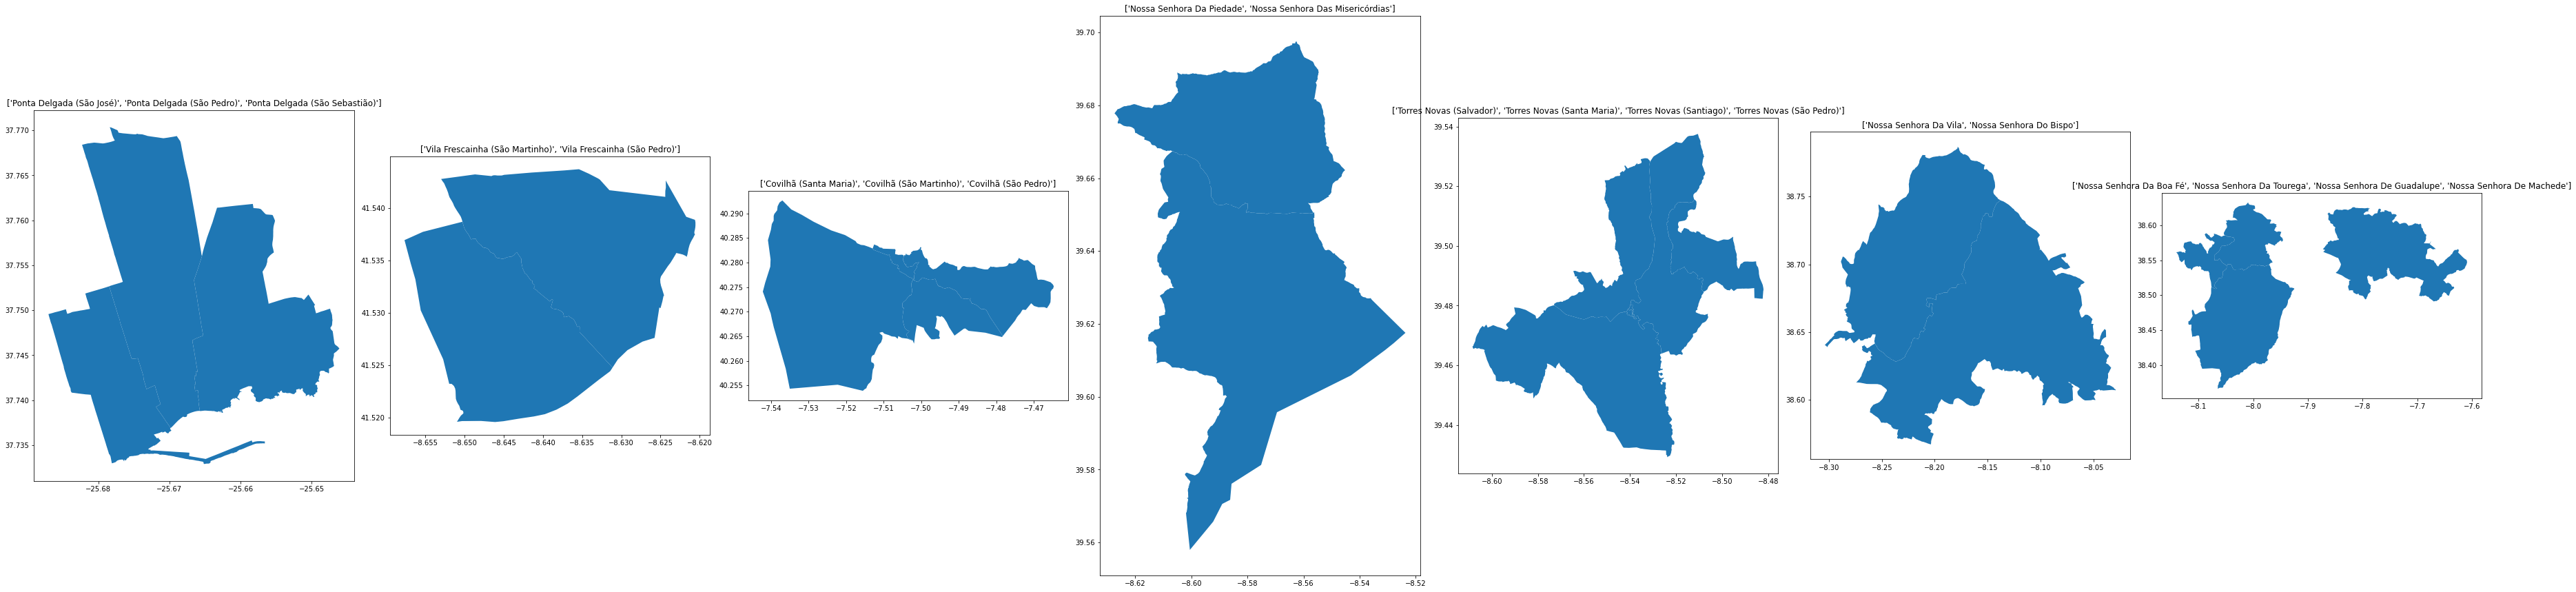

In [190]:
df = data_boundaries[(data_boundaries['NAME_0'] == 'Portugal') & (data_boundaries['NAME_3'].str.contains('Ponta Delgada|Vila Frescainha|Covilhã|Torres Novas|Nossa Senhora'))]
frag_cities = get_fragmented_cities_clustering(df, level=3)
visual_validation(frag_cities, df, level=3)